# 10 Confusing XGBoost Hyperparameters and How to Tune Them Like a Pro in 2023
## XGBoost hyperparameters done with style and visuals
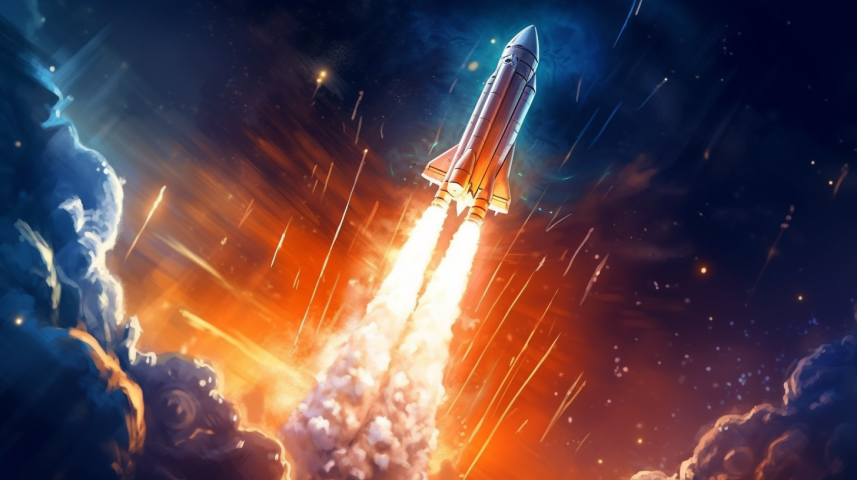

### Intro

Today, I am going to show you how to squeeze XGBoost so hard that the both 'o's pop out. We will do it by __tuning__ its hyperparameters so right and precise that it will no longer be able to _bst_ after giving us all the performance it can.

This isn't going to be a hyperparameter checklist post. No. I will explain each and every of the _ten_ hyperparameters (with visuals), what they do, their accepted ranges, the best practices and how Optuna can be used to tune them. 

Let's get started!

### What we wanted all along...

A dumb, underfit XGBoost is unheard of. Honestly, even with default parameter values, it performs reasonably well on many tabular tasks. Its biggest problem is _over-effing-fitting_.

To fix the issue, most XGBoost hyperparameters are put there to tame the underlying beast so that it doesn't just swallow up the training set and burp up the bones during testing. 

So, by doing hyperparameter tuning, we want to strike the perfect balance between a complex model that overfits and a tamed simple model that generalizes well on unseen data.

Parameters that control overfitting are:

- `eta`
- `num_boost_round`
- `max_depth`
- `subsample`
- `colsample_bytree`
- `gamma`
- `min_child_weight`
- `lambda`
- `alpha`

We will see how to tune these and a couple more after learning what they do.

### Sklearn XGBoost vs. Native XGBoost

I really struggle with these two as Sklearn is my favorite library while XGBoost is my favorite library name (it fits perfectly with `bexgboost` - domain taken).

But when it comes to objective facts, the native XGBoost training API has a slight edge of the Sklearn API in terms of flexibility and access to more advanced and nuanced features. 

I agree that the Scikit-learn API integrates with the Sklearn ecosystem (pipelines, cross-validators, and all the rest) very well but for this article, we will stick to the native API.

Here is some sample code to remind you:

```python
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define the XGBoost parameters
params = {
    "objective": "binary:logistic",
    "tree_method": "gpu_hist",  # Specify GPU histogram-based method
    # The rest of the params goes here
}

# Convert the data into DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train the XGBoost model
num_rounds = 100
model = xgb.train(params, dtrain, num_boost_round=num_rounds)
```

But for those who are dead set, I will add the hyperparameter aliases for the Sklearn API as well.

### The story of 10 parameters

__0. `objective` - No Sklearn alias__

First, you have to determine your path in the woods by setting an `objective` (XGBoost is tree-based, ensemble model):

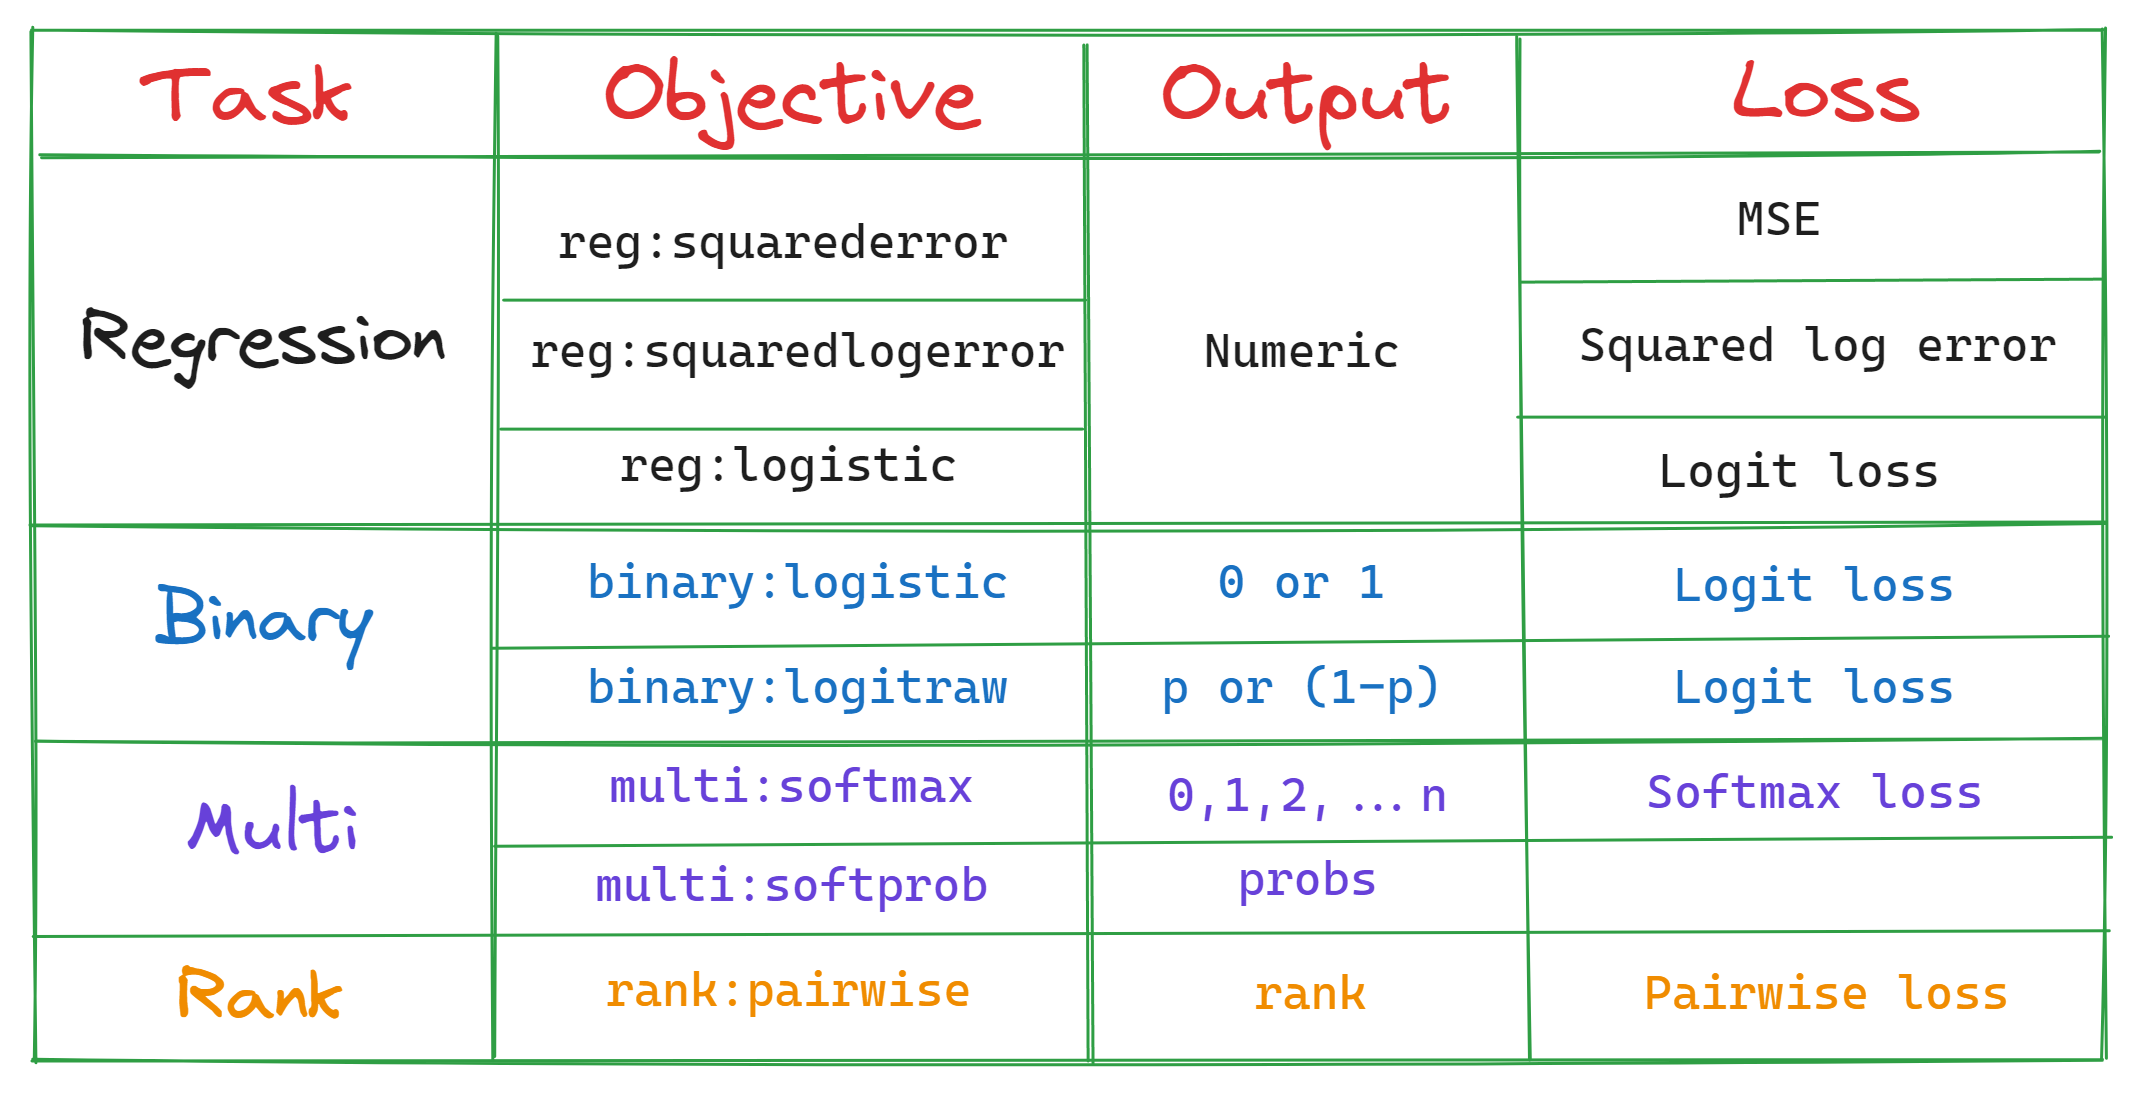

`objective` directly influences the kind of decision trees and the loss function to use. 

__1. `num_boost_round` - `n_estimators`__

Afterwards, you have to determine the number of decision trees (often called base learners in XGBoost) to plant during training using `num_boost_round`. The default is 100 but that's hardly enough for today's large datasets. 

Increasing the parameter will plant more trees but significantly increases the chances of overfitting as the model becomes more complex.

One trick I learned from Kaggle is to set a high number like 100,000 for `num_boost_round` and make use of __early stopping rounds__.

In each boosting round, XGBoost plants one more decision tree to improve the score of the last one. That's why it is called boosting. This process continues until `num_boost_round` end, regardless whether each new round is an improvement on the last. 

But by using early stopping, we can stop the training and thus planting of more trees when the score hasn't been improving for the last 5, 10, 50 or any arbitrary number of rounds.

With this trick, we can find the perfect number of decision trees without even tuning `num_boost_round` . Here is how it would look in code:

```python
# Define the rest of the params
params = {...}

# Build the train/validation sets
dtrain_final = xgb.DMatrix(X_train, label=y_train)
dvalid_final = xgb.DMatrix(X_valid, label=y_valid)

bst_final = xgb.train(
    params,
    dtrain_final,
    num_boost_round=100000 # Set a high number
    evals=[(dvalid_final, "validation")],
    early_stopping_rounds=50, # Enable early stopping
    verbose_eval=False,
)
```

The above code would make XGBoost use 100k decision trees but it will stop when the validation score hasn't been improving for the last 50 rounds. Usually, the number of required trees will be less than 10,000.

Controlling `num_boost_round` is also one of the biggest factors in how long the training process runs as more trees require more resources.

__2. `eta` - `learning_rate`__

In each round, all existing trees return a prediction on the given input. For example, in the fifth round of boosting, the five trees may return the following predictions for sample N:

1. Tree 1: 0.57
2. Tree 2: 0.9
3. Tree 3: 4.25
4. Tree 4: 6.4
5. Tree 5: 2.1

To return a final prediction, these outputs need to be summed up but before that, XGBoost shrinks or scales them using a parameter called `eta` or learning rate. After scaling, the final output will be:

```python
output = learning_rate * (0.57 + 0.9 + 4.25 + 6.4 + 2.1)
```

A large learning rate gives a bigger weight to the contribution of each tree in the ensemble but this may lead to overfitting or instability but faster training times. Conversely, lower learning rate dampens the contribution of each tree, making the learning process slower but more robust. 

This regularization effect of learning rate parameter is especially useful complex and noisy datasets.

Learning rate has an inverse relationship with other parameters such as `num_boost_round`, `max_depth`, `subsample`, and `colsample_bytree`. Lower learning rate requires higher values for these parameters and vice versa. But you don't to worry about the interplay between these parameters as the hyperparameter tuner will find the best combination.

__3, 4. `subsample` and `colsample_bytree`__

Subsampling is a form of bagging that introduces more randomness into training and hence, help combat overfitting more. 

`subsample=0.7` means that each decision tree in the ensemble will train on 70% of the available data, selected randomly. A value of 1.0 indicates that all rows will be used (no subsampling).

Similar to `subsample`, there is also `colsample_bytree`. As the name implies, `colsample_bytree` controls the fraction of features each decision tree will use. `colsample_bytree=0.8` makes each tree use the random 80% of the available features (columns) in each tree.

Adjusting these two parameters allows you to control the trade-off between bias and variance. Using smaller values reduces the correlation among the trees and increases the diversity in the ensemble, which can help improve generalization and reduce overfitting. However, it may also introduce more noise and increase the bias of the model. Conversely, using larger values increase the correlation among the trees, reducing the diversity and potentially leading to overfitting.

__5. `max_depth`__

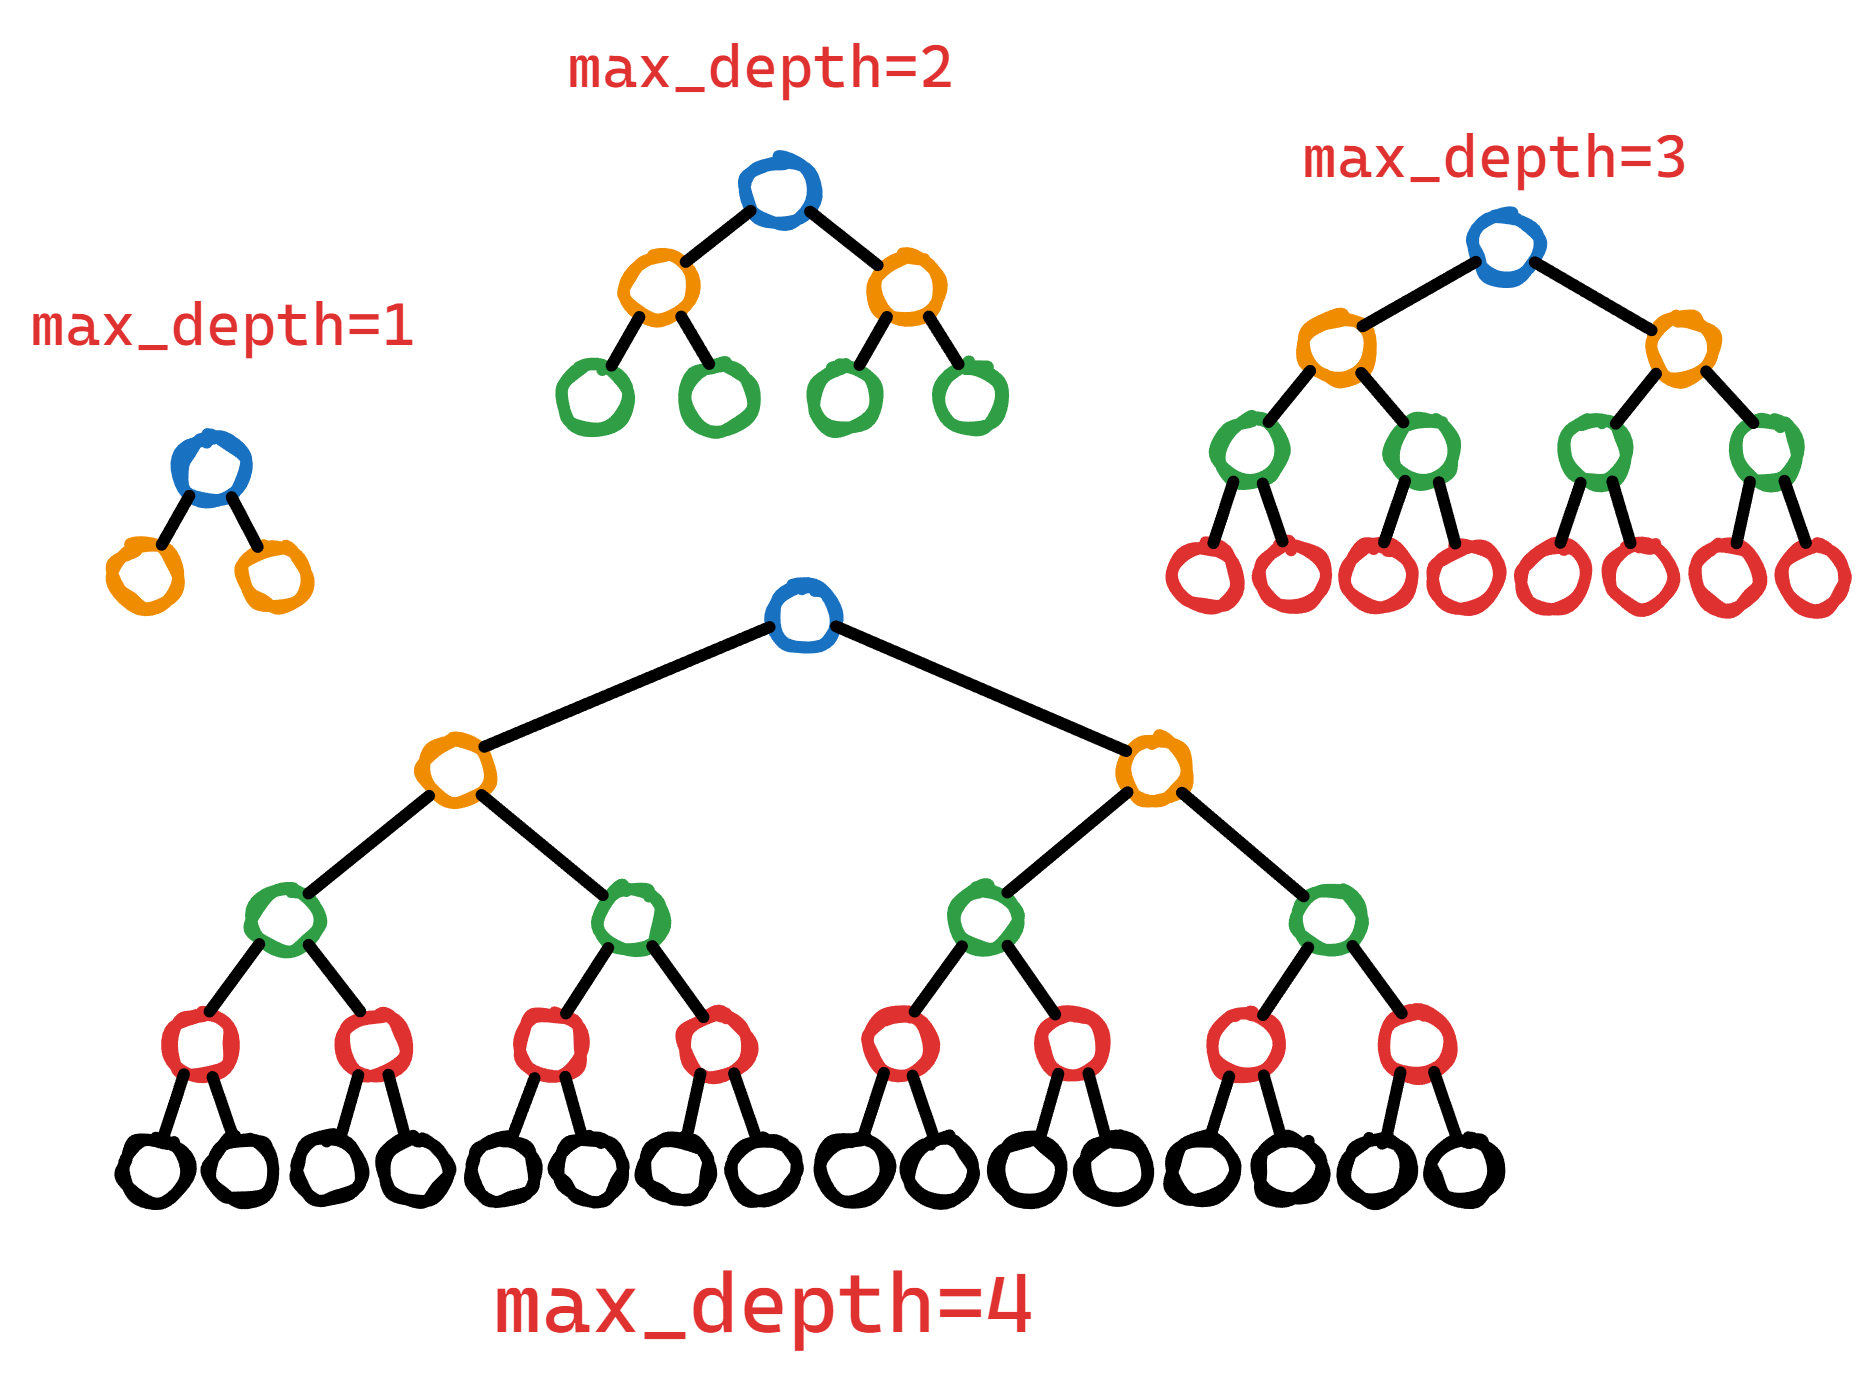

Max depth controls the maximum number of levels a decision tree may reach during training.

Deeper trees can capture more complex interactions among features. However, deeper trees also have a higher risk of overfitting, as they can memorize noise or irrelevant patterns in the training data. 

To control this complexity, `max_depth` is limited sometimes, leading to shallower trees that are simpler, capturing more general patterns. 

`max_depth` is a great balancer between complexity and generalization.

__6, 7. `alpha`, `lambda`__

`alpha` (L1) and `lambda` (L2) are yet two other regularization parameters to help with overfitting. 

Their difference between other regularization parameters is that they can shrink the weights of unimportant or insignificant features down to 0 (especially `alpha`), leading to a model with fewer features and thus, less complexity. 

The effect of `alpha` and `lambda` can be influenced by other parameters such as `max_depth`, `subsample`, and `colsample_bytree`. Higher values of `alpha` or `lambda` may require adjusting other parameters to compensate for the increased regularization. For example, a higher `alpha` value may benefit from a larger `subsample` value to maintain model diversity and prevent underfitting.

__8. `gamma`__

If you read XGBoost docs, it says that `gamma` is:

> the minimum loss reduction required to make a further partition on a leaf node of the tree.

I think the sentence doesn't make sense to anyone other than the person who wrote it. Let's break it down.

The following is a decision tree with two levels:

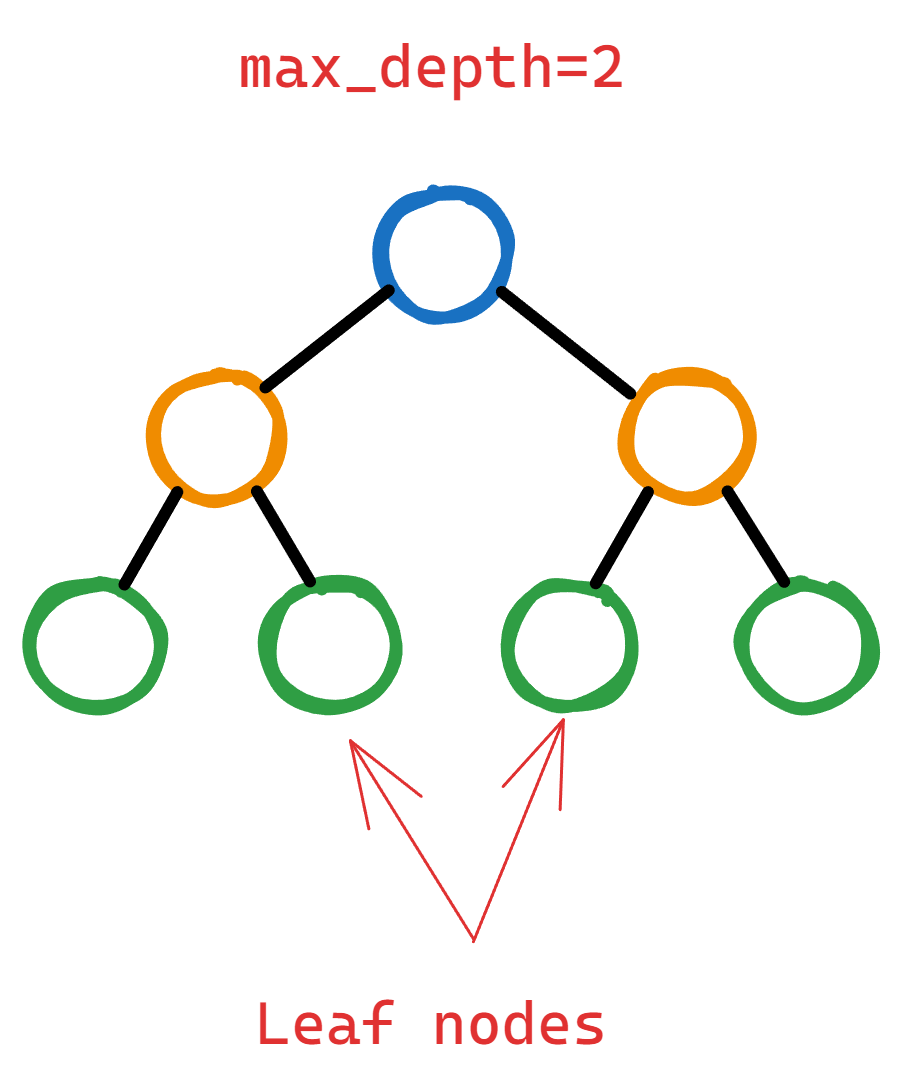

To justify adding more layers to the tree by splitting the leaf nodes, XGBoost should calculate that this operation should significantly lower the loss function. 

But 'how much significantly?' you may ask. That's where we set `gamma` - it acts as a threshold for deciding whether a leaf node should be split further.

If the reduction in loss function (often called __gain__) is less than chosen `gamma` after a potential split, then the split is not performed. This means the leaf node will remain the same and the tree won't grow from that point on. 

So, the goal from tuning `gamma` is to find the best splits that lead to the greatest reduction in the loss function, which signifies improved model performance.

### Conclusion

In [11]:
import optuna
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Load the dataset
X, y = load_boston(return_X_y=True)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define the objective function for Optuna
def objective(trial):
    params = {
        "n_jobs": -1,
        "seed": 42,
        "tree_method": "gpu_hist",
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_loguniform(
            "learning_rate", 0.01, 0.1
        ),
    }

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)

    # Train the model with early stopping
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=100000,
        evals=[(dvalid, "validation")],
        early_stopping_rounds=10,
        verbose_eval=False,
    )

    # Get the best iteration and corresponding evaluation metric
    best_iteration = bst.best_iteration
    best_score = bst.best_score

    return best_score


# Run the hyperparameter optimization with Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and evaluation metric
best_params = study.best_params
best_score = study.best_value
print("Best Hyperparameters: ", best_params)
print("Best Score: ", best_score)

/home/bexgboost/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housin

KeyboardInterrupt: 